In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import string
import sys

import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.font_manager as fm
import superscreen as sc

sys.path.append("../code/squids")
import hypres

# figure_dir = None
figure_dir = "../latex/figures"

In [2]:
squid = hypres.small.make_squid()

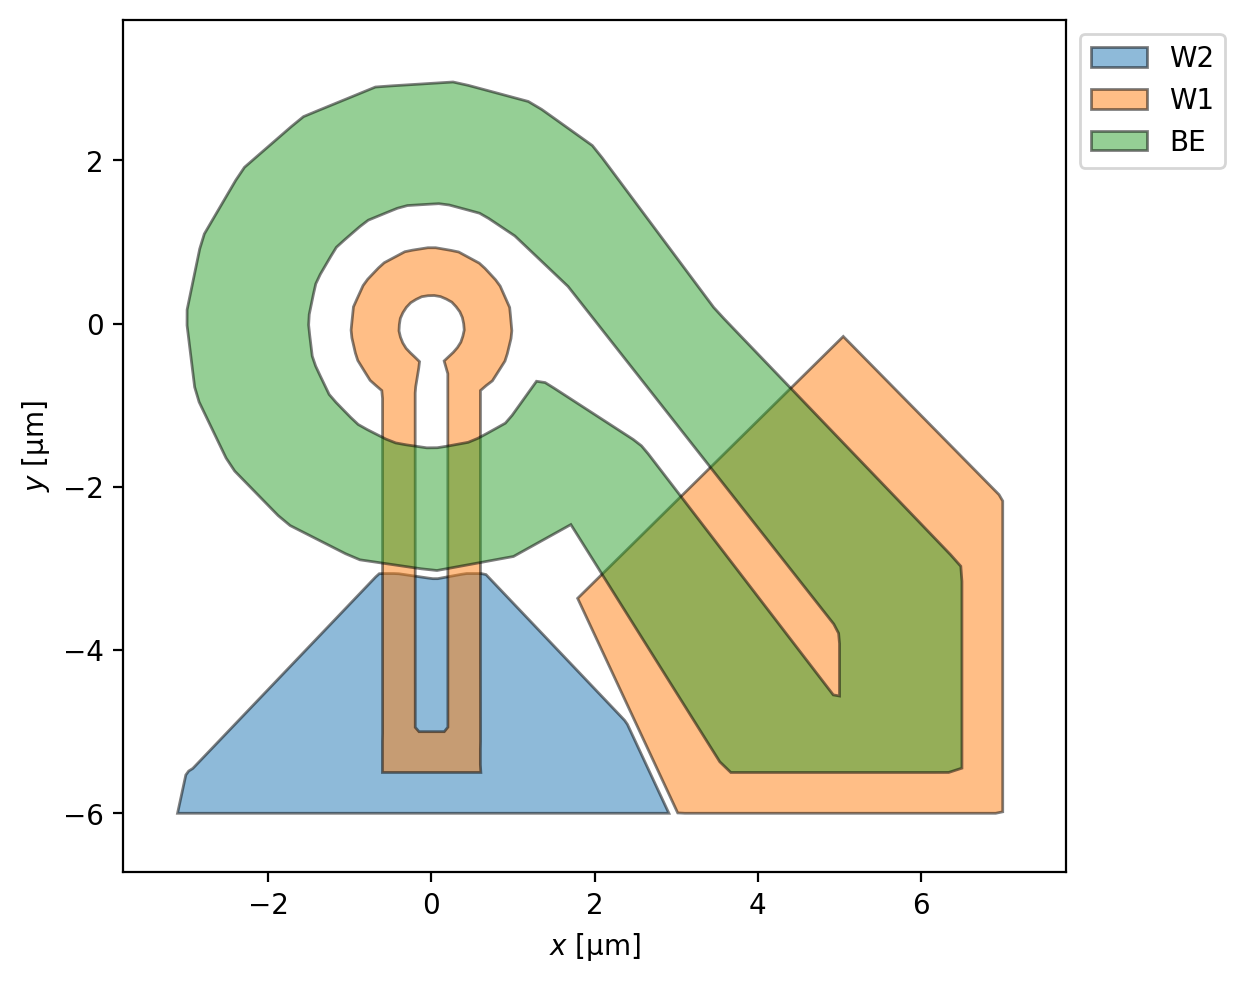

In [3]:
fig, ax = squid.draw(exclude="bounding_box", legend=True)

In [4]:
squid.solve_dtype = "float32"
squid.make_mesh(min_points=5000, smooth=100)

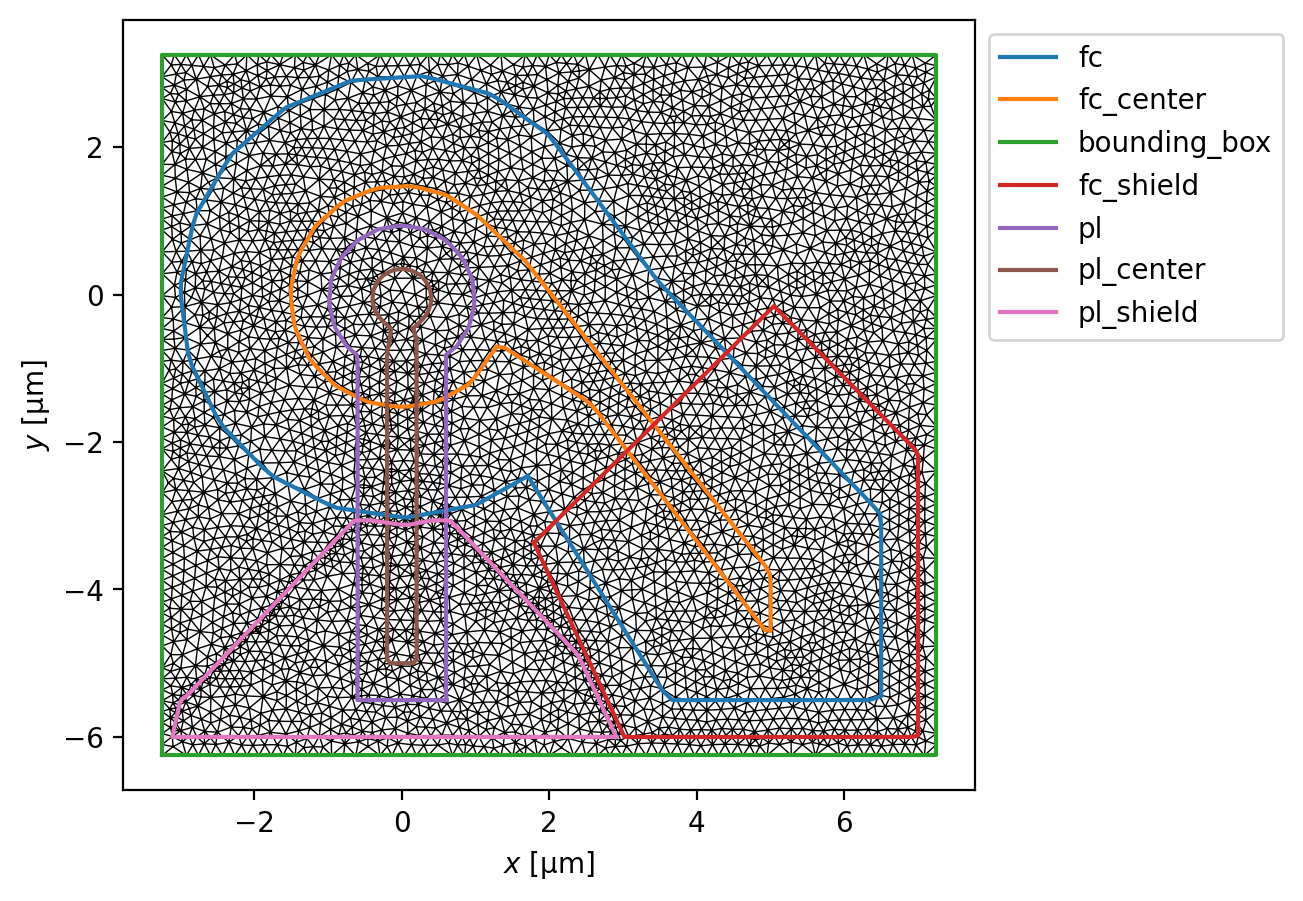

In [5]:
_ = squid.plot(mesh=True)

In [6]:
squid_solution = sc.solve(
    squid,
    circulating_currents=dict(fc_center=1),
    current_units="mA",
    field_units="mT",
    iterations=5,
)[-1]

In [7]:
z0 = 0.5  # SQUID height

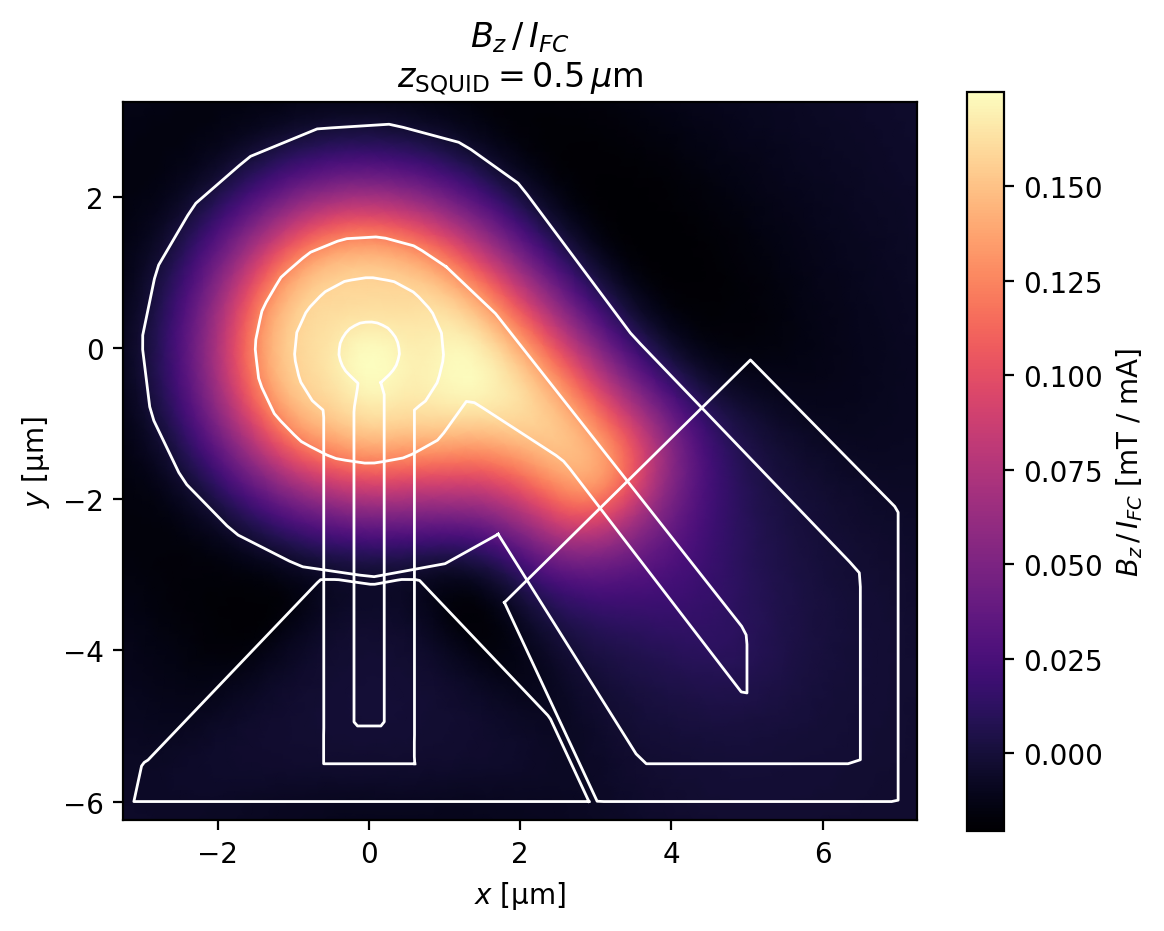

In [8]:
fig, ax = squid_solution.plot_field_at_positions(squid.points, zs=-z0, cmap="magma")
for a in ax:
    a.collections[0].colorbar.set_label("$B_z\\,/\\,I_{{FC}}$ [mT / mA]")
    a.set_title(f"$B_z\\,/\\,I_{{FC}}$\n$z_\\mathrm{{SQUID}}={{{z0}}}\\,\\mu\\mathrm{{m}}$")
    
    for polygon in squid.polygons.values():
        if polygon.name == "bounding_box":
            continue
        polygon.plot(ax=a, color="w", lw=1)

In [9]:
points, triangles = sc.Polygon(
    points=sc.geometry.box(13, center=(0.5, 0.5))
).make_mesh(min_points=4000, smooth=100)
Hz = squid_solution.field_at_position(points, zs=-z0, units="mT").m
A = squid_solution.vector_potential_at_position(points, zs=-z0, units="mT * um").m

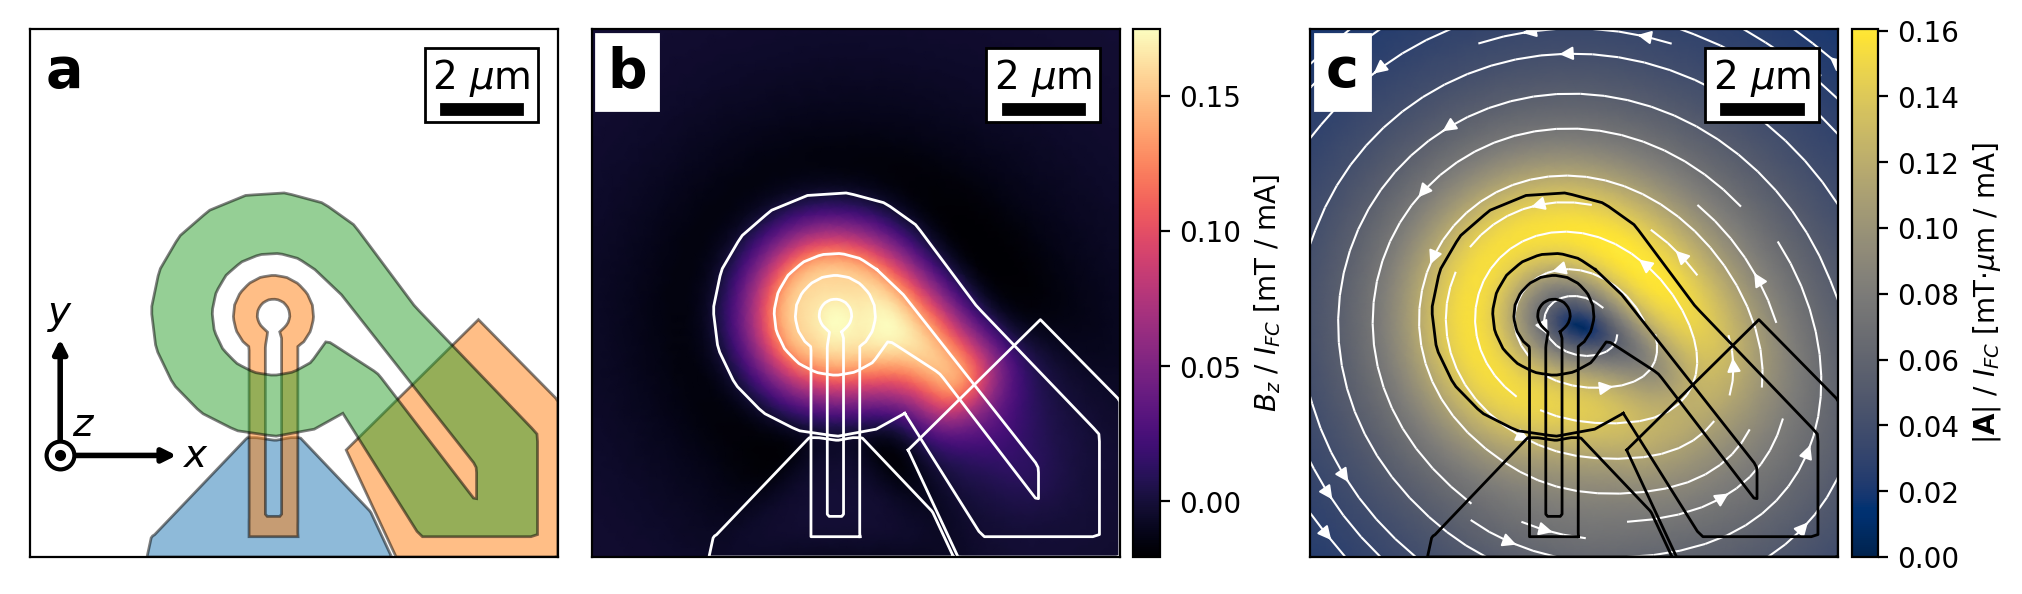

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(10, 2.85), constrained_layout=True)
    
ax, bx, cx = axes

xs = points[:, 0]
ys = points[:, 1]
ts = triangles

N = 101
x = np.linspace(xs.min(), xs.max(), N)
y = np.linspace(ys.min(), ys.max(), N)
X, Y = np.meshgrid(x, y)

Ax = griddata(points, A[:, 0], (X, Y))
Ay = griddata(points, A[:, 1], (X, Y))


squid.draw(ax=ax, exclude=["bounding_box", "pl_hole", "fc_hole"])

im = bx.tripcolor(xs, ys, Hz, triangles=ts, shading="gouraud", cmap="magma")
bx.tricontour(xs, ys, ts, Hz, levels=[0], colors="w",  alpha=0, zorder=100)
im.set_rasterized(True)
cbar_bx = fig.colorbar(im, ax=bx, pad=0.025)
cbar_bx.set_ticks([0, 0.05, 0.1, 0.15])
cbar_bx.set_label("$B_z$ / $I_{{FC}}$ [mT / mA]")


norm = np.linalg.norm(A, axis=1)
unit = A / norm[:, np.newaxis]
im = cx.tripcolor(xs, ys, ts, norm, shading="gouraud", cmap="cividis", vmin=0, vmax=None)
cx.streamplot(x, y, Ax, Ay, linewidth=0.75, color="w", density=0.55, broken_streamlines=True)
im.set_rasterized(True)
cbar_cx = fig.colorbar(im, ax=cx, pad=0.025)
cbar_cx.set_label("$|\\mathbf{A}|$ / $I_{{FC}}$ [mT$\\cdot\\mu$m / mA]")

for a, c, alpha in zip((bx, cx), ("w", "k"), (1, 1)):
    for polygon in squid.polygons.values():
        if polygon.name == "bounding_box":
            continue
        polygon.plot(ax=a, color=c, lw=1, ls="-", alpha=alpha)
    
ax.set_xlim(*bx.get_xlim())
ax.set_ylim(*bx.get_ylim())
cx.set_xlim(*bx.get_xlim())
cx.set_ylim(*bx.get_ylim())
        
scale = 2
for a, s, color in zip(axes, string.ascii_lowercase, ["none", "white", "white"]):
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")

    scalebar = AnchoredSizeBar(
        a.transData,
        scale,
        f"{scale} $\\mu$m",
        "upper right",
        pad=0.2,
        borderpad=0.5,
        size_vertical=0.25,
        label_top=True,
        fontproperties=fm.FontProperties(size=14),
    )
    a.add_artist(scalebar)
    
    a.text(
        0.03, 0.97, s,
        ha="left", va="top",
        fontweight="bold", size=20, transform=a.transAxes,
        backgroundcolor=color,
    )
    
def add_arrow(ax, start, end):
    ax.annotate(
        text="",
        xy=end,
        xytext=start,
        arrowprops=dict(arrowstyle="-|>", lw=2, color="k"),
    )
    
axes_length = 3
r0 = np.array([-5.25, -3.5])
add_arrow(ax, r0, r0 + [0, axes_length])
add_arrow(ax, r0, r0 + [axes_length, 0])
ax.scatter(*r0, color="k", marker="o", s=100, facecolor="white", lw=1.5, zorder=100)
ax.scatter(*r0, color="k", marker=".", s=25, facecolor="k", lw=1.5, zorder=101)
ax.text(*(r0 + [axes_length, 0]), "$x$", ha="left", va="center", size=14)
ax.text(*(r0 + [0, axes_length]), "$y$", ha="center", va="bottom", size=14)
ax.text(*(r0 + [axes_length / 10, axes_length / 10]), "$z$", ha="left", va="bottom", size=14)

if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "squid-outline.pdf"), bbox_inches="tight")

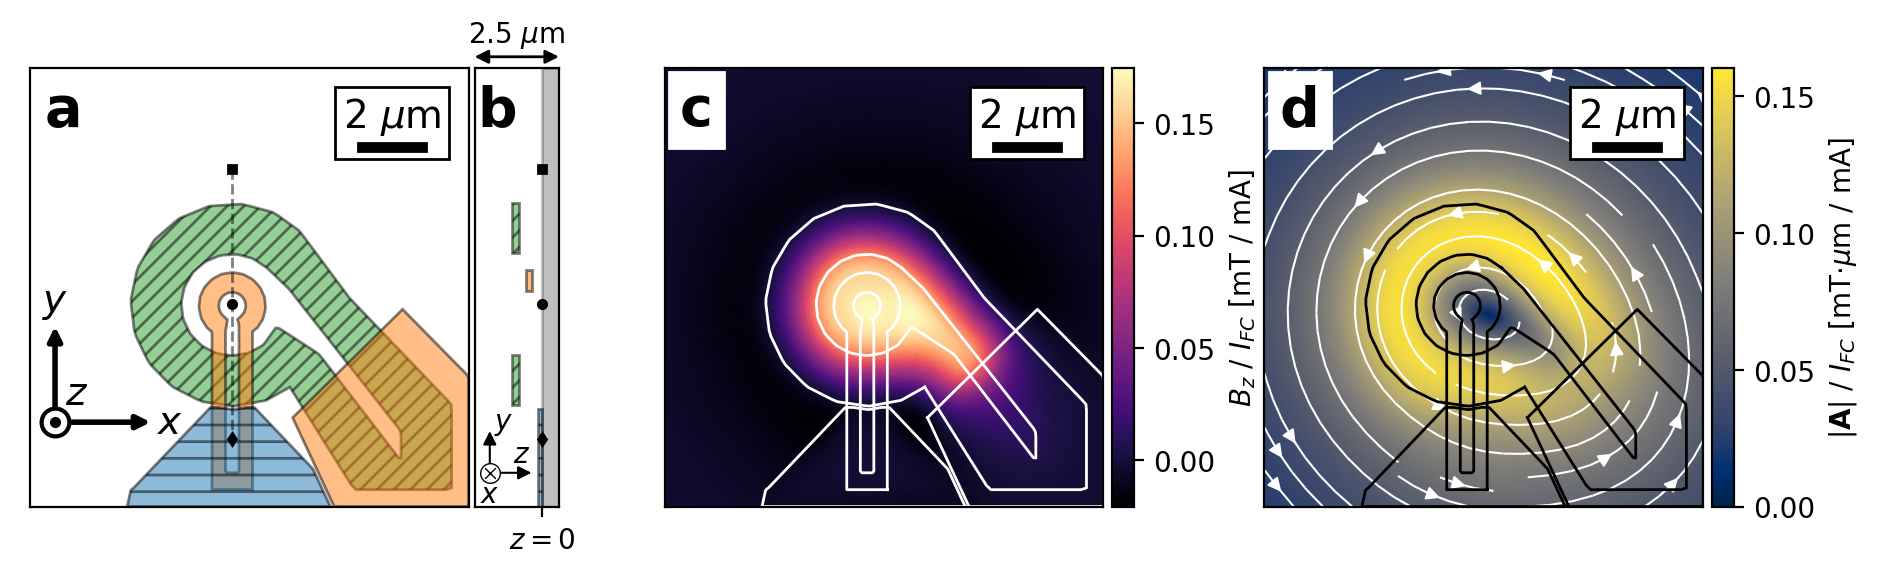

In [11]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(9.25, 2.75),
    constrained_layout=True,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)
    
ax, cx, dx = axes

xs = points[:, 0]
ys = points[:, 1]
ts = triangles

N = 101
x = np.linspace(xs.min(), xs.max(), N)
y = np.linspace(ys.min(), ys.max(), N)
X, Y = np.meshgrid(x, y)

Ax = griddata(points, A[:, 0], (X, Y))
Ay = griddata(points, A[:, 1], (X, Y))


layers = squid.layers

patches = squid.patches()
layer_colors = dict(BE="C2", W1="C1", W2="C0")
hatch_styles = dict(BE="////", W1=None, W2="--")
for layer, color in layer_colors.items():
    for patch in patches[layer].values():
        patch.set_hatch(hatch_styles[layer])
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
        
ax.add_patch(patches["BE"]["fc"])
ax.add_patch(patches["W1"]["pl"])
ax.add_patch(patches["W1"]["fc_shield"])
ax.add_patch(patches["W2"]["pl_shield"])

cbar_kw = dict(pad=0.025)
cax_kw = dict(size="5%", pad="2%")

im = cx.tripcolor(xs, ys, Hz, triangles=ts, shading="gouraud", cmap="magma")
cx.tricontour(xs, ys, ts, Hz, levels=[0], colors="w",  alpha=0, zorder=100)
cdivider = make_axes_locatable(cx)
ccax = cdivider.append_axes("right", **cax_kw)
im.set_rasterized(True)
cbar_cx = fig.colorbar(im, cax=ccax, **cbar_kw)
cbar_cx.set_ticks([0, 0.05, 0.1, 0.15])
cbar_cx.set_label("$B_z$ / $I_{{FC}}$ [mT / mA]")
cbar_cx.set_ticks([0, 0.05, 0.1, 0.15])

norm = np.linalg.norm(A, axis=1)
unit = A / norm[:, np.newaxis]
im = dx.tripcolor(xs, ys, ts, norm, shading="gouraud", cmap="cividis", vmin=0, vmax=None)
dx.streamplot(x, y, Ax, Ay, linewidth=0.75, color="w", density=0.55, broken_streamlines=True)
ddiviver = make_axes_locatable(dx)
dcax = ddiviver.append_axes("right", **cax_kw)
im.set_rasterized(True)
cbar_dx = fig.colorbar(im, cax=dcax, **cbar_kw)
cbar_dx.set_label("$|\\mathbf{A}|$ / $I_{{FC}}$ [mT$\\cdot\\mu$m / mA]")
cbar_dx.set_ticks([0, 0.05, 0.1, 0.15])

for a, c, alpha in zip((cx, dx), ("w", "k"), (1, 1)):
    for polygon in squid.polygons.values():
        if polygon.name == "bounding_box":
            continue
        polygon.plot(ax=a, color=c, lw=1, ls="-", alpha=alpha)
    
ax.set_xlim(*cx.get_xlim())
ax.set_ylim(*cx.get_ylim())
dx.set_xlim(*cx.get_xlim())
dx.set_ylim(*cx.get_ylim())
        
scale = 2
for a in [ax, cx, dx]:
    a.set_aspect("equal")
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel("")
    a.set_ylabel("")

    scalebar = AnchoredSizeBar(
        a.transData,
        scale,
        f"{scale} $\\mu$m",
        "upper right",
        pad=0.2,
        borderpad=0.5,
        size_vertical=0.25,
        label_top=True,
        fontproperties=fm.FontProperties(size=14),
    )
    a.add_artist(scalebar)
    
def add_arrow(ax, start, end, lw=2):
    ax.annotate(
        text="",
        xy=end,
        xytext=start,
        arrowprops=dict(arrowstyle="-|>", lw=lw, color="k"),
    )
    
axes_length = 3
r0 = np.array([-5.25, -3.5])
add_arrow(ax, r0, r0 + [0, axes_length])
add_arrow(ax, r0, r0 + [axes_length, 0])
ax.scatter(*r0, color="k", marker="o", s=100, facecolor="white", lw=1.5, zorder=100)
ax.scatter(*r0, color="k", marker=".", s=25, facecolor="k", lw=1.5, zorder=101)
ax.text(*(r0 + [axes_length, 0]), "$x$", ha="left", va="center", size=14)
ax.text(*(r0 + [0, axes_length]), "$y$", ha="center", va="bottom", size=14)
ax.text(*(r0 + [axes_length / 10, axes_length / 10]), "$z$", ha="left", va="bottom", size=14)

y0 = 0
ys = np.linspace(4, -4, 101)
xs = np.zeros_like(ys)
ax.plot(xs, ys + y0, "k--", lw=1, alpha=0.5)
ax.plot(0, 0, "ko", markersize=3)
ax.plot(0, ys[0], "ks", markersize=3)
ax.plot(0, ys[-1], "kd", markersize=3)

bx = ax.inset_axes([0.96, 0, 0.3, 1])
bx.sharey(ax)

bx.axvspan(0, 0.5, color="k", alpha=0.25)

# bx.plot(xs, ys + y0, "k--", lw=1, alpha=0.5)
bx.plot(0, 0, "ko", markersize=3)
bx.plot(0, ys[0], "ks", markersize=3)
bx.plot(0, ys[-1], "kd", markersize=3)

ro_fc = 3.0
ri_fc = 1.5
fc_width = ro_fc - ri_fc
ro_pl = 1.0
ri_pl = 0.4
pl_width = ro_pl - ri_pl

rect_kw = dict(edgecolor="k", alpha=0.5)

fc1 = mpl.patches.Rectangle(
    (-layers["BE"].z0, ri_fc),
    height=fc_width,
    width=-layers["BE"].thickness,
    facecolor=layer_colors["BE"],
    **rect_kw,
)
fc2 = mpl.patches.Rectangle(
    (-layers["BE"].z0, -ri_fc),
    height=-fc_width,
    width=-layers["BE"].thickness,
    facecolor=layer_colors["BE"],
    **rect_kw,
)
pl1 = mpl.patches.Rectangle(
    (-layers["W1"].z0, ri_pl),
    height=pl_width,
    width=-layers["W1"].thickness, 
    facecolor=layer_colors["W1"],
    **rect_kw,
)
pl_shield = mpl.patches.Rectangle(
    (-layers["W2"].z0, -(ro_fc + 0.1)),
    height=-5,
    width=-layers["W2"].thickness,
    facecolor=layer_colors["W2"],
    **rect_kw,
)

fc1.set_hatch("////")
fc2.set_hatch("////")
pl_shield.set_hatch("--")

bx.add_artist(fc1)
bx.add_artist(pl1)
bx.add_artist(fc2)
bx.add_artist(pl_shield)

bx.set_xlim(-2, 0.5)
bx.set_yticks([-4, 0, 4])

bx.set_yticks([])
bx.set_ylabel("")
bx.set_xticks([0])
bx.set_xticklabels(["$z=0$"], fontsize=10)
bx.set_xlabel("")
bx.set_aspect("equal")

axes_length = 1.4
r0 = np.array([-1.55, -5])
add_arrow(bx, r0, r0 + [0, axes_length], lw=0.75)
add_arrow(bx, r0, r0 + [axes_length, 0], lw=0.75)
bx.scatter(*r0, color="k", marker="o", s=50, facecolor="white", lw=0.5, zorder=100)
bx.scatter(*r0, color="k", marker="x", s=15, facecolor="k", lw=0.5, zorder=101)
bx.text(*(r0 + [axes_length * 0.5, axes_length * 0.4]), "$z$", ha="left", va="center", size=10)
bx.text(*(r0 + [axes_length * 0.3, axes_length * 0.75]), "$y$", ha="center", va="bottom", size=10)
bx.text(*(r0 + [0, -axes_length * 0.165]), "$x$", ha="center", va="top", size=10)

bx.annotate(
    "",
    xy=(0, 1.025),
    xytext=(1, 1.025),
    arrowprops=dict(arrowstyle="<|-|>", color="k", shrinkA=0, shrinkB=0, lw=1),
    textcoords=bx.transAxes,
    xycoords=bx.transAxes,
)
bx.text(
    0.5, 1.04, "2.5 $\\mu$m",
    size=10, ha="center", va="bottom",
    transform=bx.transAxes,
)

for a, s, color in zip([ax, bx, cx, dx], string.ascii_lowercase, ["none", "none", "white", "white"]):
    a.text(
        0.035, 0.965, s,
        ha="left", va="top",
        fontweight="bold", size=20, transform=a.transAxes,
        backgroundcolor=color,
    )
    
if figure_dir is not None:
    fig.set_facecolor("white")
    fig.savefig(os.path.join(figure_dir, "squid-outline-cut.pdf"), bbox_inches="tight")

In [12]:
Hz.max()

0.17470176540679125

In [13]:
import superscreen

superscreen.version_table()

Software,Version
SuperScreen,0.8.1
Numpy,1.23.3
SciPy,1.9.1
matplotlib,3.6.0
ray,2.2.0
jax,0.3.18
IPython,8.5.0
Python,"3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) [Clang 13.0.1 ]"
OS,posix [darwin]
Number of CPUs,"Physical: 10, Logical: 10"
